# Requirements

In [1]:
import os, sys

pkg_path = 'D:\\Projects\\System_Trading\\JnQ\\'

os.chdir(pkg_path)

pakage_name = 'Bank'

# mpl_finance_path = 'D:\\python\\python38_1\\projects\\JnQ\\mpl_finance'
# ta_lib_path = 'D:\\python\\python38_1\\projects\\JnQ\\ta_lib'
funcs_path = pkg_path + 'funcs'

if funcs_path not in sys.path:

  try:
    # sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/JnQ')
    sys.path.insert(0, pkg_path + '\\{}'.format(pakage_name))
    sys.path.insert(0, funcs_path)
    # sys.path.insert(0, mpl_finance_path)
    # sys.path.insert(0, ta_lib_path)
    
  except Exception as e:
    print(e)


In [2]:
import logging
import logging.config
from PyQt5.QtWidgets import QApplication
from PyQt5.QAxContainer import QAxWidget
from PyQt5.QtCore import QEventLoop
from pykiwoom import parser  # 미 선언시 IDEP restart 됨.
import pythoncom

from funcs.kiwoom.constant import *
from funcs.kiwoom.error import *

from pandas import DataFrame
import numpy as np
import pandas as pd
import time
from datetime import datetime

today = datetime.now()
todaystamp = today.year * 10000 + today.month * 100 + today.day 

np.seterr(invalid="ignore")
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=2000) 

pd.set_option('mode.chained_assignment',  None)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Kiwoom_custom

In [4]:

class Kiwoom(QAxWidget):
    def __init__(self):
        super().__init__()

        self.setControl("KHOPENAPI.KHOpenAPICtrl.1")

        # Loop 변수
        # 비동기 방식으로 동작되는 이벤트를 동기화(순서대로 동작) 시킬 때
        self.login_loop = None
        self.request_loop = None
        self.order_loop = None
        self.condition_loop = None

        # 서버구분
        self.server_gubun = None

        # 조건식
        self.condition = None

        # 에러
        self.error = None

        # 주문번호
        self.order_no = ""

        # 조회
        self.inquiry = 0

        # 서버에서 받은 메시지
        self.msg = ""

        # 예수금 d+2
        self.data_opw00001 = 0

        # 보유종목 정보
        self.data_opw00018 = {'account_evaluation': [], 'stocks': []}

        # 주가상세정보
        self.data_opt10081 = [] * 15
        self.data_opt10086 = [] * 23

        # signal & slot
        self.OnEventConnect.connect(self.event_connect)
        self.OnReceiveTrData.connect(self.on_receive_tr_data)
        self.OnReceiveChejanData.connect(self.on_receive_chejan_data)
        self.OnReceiveRealData.connect(self.receive_real_data)
        self.OnReceiveMsg.connect(self.receive_msg)
        self.OnReceiveConditionVer.connect(self.receive_condition_ver)
        self.OnReceiveTrCondition.connect(self.receive_tr_condition)
        self.OnReceiveRealCondition.connect(self.receive_real_condition)

        # 로깅용 설정파일
        logging.config.fileConfig('D:\Projects\System_Trading\PyTrader\logging.conf')
        self.log = logging.getLogger('Kiwoom')

    ###############################################################
    # 로깅용 메서드 정의                                               #
    ###############################################################

    def logger(origin):
        def wrapper(*args, **kwargs):
            args[0].log.debug('{} args - {}, kwargs - {}'.format(origin.__name__, args, kwargs))
            return origin(*args, **kwargs)

        return wrapper

    ###############################################################
    # 이벤트 정의                                                    #
    ###############################################################

    def event_connect(self, return_code):
        """
        통신 연결 상태 변경시 이벤트
        return_code 0이면 로그인 성공
        그 외에는 ReturnCode 클래스 참조.
        :param return_code: int
        """
        try:
            if return_code == ReturnCode.OP_ERR_NONE:
                if self.get_login_info("GetServerGubun", True):
                    self.msg += "실서버 연결 성공" + "\r\n\r\n"
                else:
                    self.msg += "모의투자서버 연결 성공" + "\r\n\r\n"
            else:
                self.msg += "연결 끊김: 원인 - " + ReturnCode.CAUSE[return_code] + "\r\n\r\n"
        except Exception as error:
            self.log.error('eventConnect {}'.format(error))
        finally:
            # commConnect() 메서드에 의해 생성된 루프를 종료시킨다.
            # 로그인 후, 통신이 끊길 경우를 대비해서 예외처리함.
            try:
                self.login_loop.exit()
            except AttributeError:
                pass

    def receive_msg(self, screen_no, request_name, tr_code, msg):
        """
        수신 메시지 이벤트
        서버로 어떤 요청을 했을 때(로그인, 주문, 조회 등), 그 요청에 대한 처리내용을 전달해준다.
        :param screen_no: string - 화면번호(4자리, 사용자 정의, 서버에 조회나 주문을 요청할 때 이 요청을 구별하기 위한 키값)
        :param request_name: string - TR 요청명(사용자 정의)
        :param tr_code: string
        :param msg: string - 서버로 부터의 메시지
        """

        if request_name == "서버구분":

            if msg.find('모의투자') < 0:
                self.server_gubun = 1

            else:
                self.server_gubun = 0

            try:
                self.order_loop.exit()
            except AttributeError:
                pass
            finally:
                return

        self.msg += request_name + ": " + msg + "\r\n\r\n"

    def on_receive_tr_data(self, screen_no, request_name, tr_code, record_name, inquiry, unused0, unused1, unused2,
                           unused3):
        """
        TR 수신 이벤트
        조회요청 응답을 받거나 조회데이터를 수신했을 때 호출됩니다.
        request_name tr_code comm_rq_data()메소드의 매개변수와 매핑되는 값 입니다.
        조회데이터는 이 이벤트 메서드 내부에서 comm_get_data() 메서드를 이용해서 얻을 수 있습니다.
        :param screen_no: string - 화면번호(4자리)
        :param request_name: string - TR 요청명(comm_rq_data() 메소드 호출시 사용된 requestName)
        :param tr_code: string
        :param record_name: string
        :param inquiry: string - 조회('0': 남은 데이터 없음, '2': 남은 데이터 있음)
        """

        print("on_receive_tr_data 실행: screen_no: %s, request_name: %s, tr_code: %s, record_name: %s, inquiry: %s" % (
            screen_no, request_name, tr_code, record_name, inquiry))

        # 주문번호와 주문루프
        self.order_no = self.comm_get_data(tr_code, "", request_name, 0, "주문번호")

        try:
            self.order_loop.exit()
        except AttributeError:
            pass

        self.inquiry = inquiry

        if request_name == "관심종목정보요청":
            data = self.get_comm_data_ex(tr_code, "관심종목정보")

            """ commGetData
            cnt = self.getRepeatCnt(trCode, requestName)
            for i in range(cnt):
                data = self.commGetData(trCode, "", requestName, i, "종목명")
                print(data)
            """

        if request_name == "주식일봉차트조회요청":
            data = self.get_comm_data_ex(tr_code, "주식일봉차트조회")
            if data is not None:
                data = list(map(lambda x: list(map(lambda y: y.replace('+','').replace('--','-'), x)), np.array(data)[:,1:8].tolist()))
                data = list(map(lambda x: list(map(lambda y: int(y) if y != '' else 0, x)), data))
                self.data_opt10081.extend(data)
                date = str(data[0][3])
                dt = datetime.strptime(date, "%Y%m%d")
                if dt <= self.start_date:
                    self.inquiry = 0
            if inquiry == "0" or self.inquiry == 0:
                col_name = ['현재가', '거래량', '거래대금', '일자', '시가', '고가', '저가']
                self.data_opt10081 = DataFrame(self.data_opt10081, columns=col_name)

        if request_name == "일별주가요청":
            data = self.get_comm_data_ex(tr_code, "일별주가요청")
            if data is not None:
                data = list(map(lambda x: list(map(lambda y: y.replace('+','').replace('--','-'), x)), data))
                data = list(map(lambda x: list(map(lambda y: float(y) if y != '' else 0, x)), data))
                self.data_opt10086.extend(data)
                date = str(int(data[0][0]))
                dt = datetime.strptime(date, "%Y%m%d")
                if dt <= self.start_date:
                    self.inquiry = 0
            if inquiry == "0" or self.inquiry == 0:
                col_name = ['일자', '시가', '고가', '저가', '종가', '전일비', '등락률', '거래량', '금액(백만)', '신용비', '개인',
                            '기관', '외인수량', '외국계', '프로그램', '외인비', '체결강도', '외인보유', '외인비중', '외인순매수',
                            '기관순매수', '개인순매수', '신용잔고율']
                self.data_opt10086 = DataFrame(self.data_opt10086, columns=col_name)

        if request_name == "예수금상세현황요청":
            estimate_day2_deposit = self.comm_get_data(tr_code, "", request_name, 0, "d+2추정예수금")
            estimate_day2_deposit = self.change_format(estimate_day2_deposit)
            self.data_opw00001 = estimate_day2_deposit

        if request_name == '계좌평가잔고내역요청':
            # 계좌 평가 정보
            account_evaluation = []
            key_list = ["총매입금액", "총평가금액", "총평가손익금액", "총수익률(%)", "추정예탁자산"]

            for key in key_list:
                value = self.comm_get_data(tr_code, "", request_name, 0, key)

                if key.startswith("총수익률"):
                    value = self.change_format(value, 1)
                else:
                    value = self.change_format(value)
                account_evaluation.append(value)
            self.data_opw00018['account_evaluation'] = account_evaluation

            # 보유 종목 정보
            cnt = self.get_repeat_cnt(tr_code, request_name)
            key_list = ["종목명", "보유수량", "매입가", "현재가", "평가손익", "수익률(%)", "종목번호"]
            for i in range(cnt):
                stock = []
                for key in key_list:
                    value = self.comm_get_data(tr_code, "", request_name, i, key)
                    if key.startswith("수익률"):
                        value = self.change_format(value, 2)
                    elif key != "종목명" and key != "종목번호":
                        value = self.change_format(value)
                    stock.append(value)
                self.data_opw00018['stocks'].append(stock)
        try:
            self.request_loop.exit()
        except AttributeError:
            pass

    def receive_real_data(self, code, real_type, real_data):
        """
        실시간 데이터 수신 이벤트
        실시간 데이터를 수신할 때 마다 호출되며,
        set_real_reg() 메서드로 등록한 실시간 데이터도 이 이벤트 메서드에 전달됩니다.
        get_comm_real_data() 메서드를 이용해서 실시간 데이터를 얻을 수 있습니다.
        :param code: string - 종목코드
        :param real_type: string - 실시간 타입(KOA의 실시간 목록 참조)
        :param real_data: string - 실시간 데이터 전문
        """

        try:
            self.log.debug("[receiveRealData]")
            self.log.debug("({})".format(real_type))

            if real_type not in RealType.REALTYPE:
                return

            data = []

            if code != "":
                data.append(code)
                codeOrNot = code
            else:
                codeOrNot = real_type

            for fid in sorted(RealType.REALTYPE[real_type].keys()):
                value = self.get_comm_real_data(codeOrNot, fid)
                data.append(value)

            # TODO: DB에 저장
            self.log.debug(data)

        except Exception as e:
            self.log.error('{}'.format(e))

    def on_receive_chejan_data(self, gubun, item_cnt, fid_list):
        print("gubun: ", gubun)
        print(self.GetChejanData(9203))
        print(self.GetChejanData(302))
        print(self.GetChejanData(900))
        print(self.GetChejanData(901))

    def get_codelist_by_market(self, market):
        func = 'GetCodeListByMarket("%s")' % market
        codes = self.dynamicCall(func)
        return codes.split(';')

    ###############################################################
    # 메서드 정의: 로그인 관련 메서드                                    #
    ###############################################################

    def comm_connect(self):
        """
        로그인을 시도합니다.
        수동 로그인일 경우, 로그인창을 출력해서 로그인을 시도.
        자동 로그인일 경우, 로그인창 출력없이 로그인 시도.
        """
        self.dynamicCall("CommConnect()")
        self.login_loop = QEventLoop()
        self.login_loop.exec_()

    def get_connect_state(self):
        """
        현재 접속상태를 반환합니다.
        반환되는 접속상태는 아래와 같습니다.
        0: 미연결, 1: 연결
        :return: int
        """
        ret = self.dynamicCall("GetConnectState()")
        return ret

    def get_login_info(self, tag, is_connect_state=False):
        """
        사용자의 tag에 해당하는 정보를 반환한다.
        tag에 올 수 있는 값은 아래와 같다.
        ACCOUNT_CNT: 전체 계좌의 개수를 반환한다.
        ACCNO: 전체 계좌 목록을 반환한다. 계좌별 구분은 ;(세미콜론) 이다.
        USER_ID: 사용자 ID를 반환한다.
        USER_NAME: 사용자명을 반환한다.
        GetServerGubun: 접속서버 구분을 반환합니다.(0: 모의투자, 그외: 실서버)
        :param tag: string
        :param is_connect_state: bool - 접속상태을 확인할 필요가 없는 경우 True로 설정.
        :return: string
        """
        if not is_connect_state:
            if not self.get_connect_state():
                raise KiwoomConnectError()

        if not isinstance(tag, str):
            raise ParameterTypeError()

        if tag not in ['ACCOUNT_CNT', 'ACCNO', 'USER_ID', 'USER_NAME', 'GetServerGubun']:
            raise ParameterValueError()

        cmd = 'GetLoginInfo("%s")' % tag
        info = self.dynamicCall(cmd)

        if tag == 'GetServerGubun' and info == "":
            if self.server_gubun == None:
                account_list = self.get_login_info("ACCNO").split(';')
                self.send_order("서버구분", "0102", account_list[0], 1, "066570", 0, 0, "05", "")
            info = self.server_gubun
        return info

    #################################################################
    # 메서드 정의: 조회 관련 메서드                                        #
    # 시세조회, 관심종목 조회, 조건검색 등 이들의 합산 조회 횟수가 1초에 5회까지 허용 #
    #################################################################

    def set_input_value(self, id, value):
        self.dynamicCall("SetInputValue(QString, QString)", id, value)

    def comm_rq_data(self, request_name, tr_code, inquiry, screen_no):
        """
        키움서버에 TR 요청을 한다.
        조회요청메서드이며 빈번하게 조회요청시, 시세과부하 에러값 -200이 리턴된다.
        :param request_name: string - TR 요청명(사용자 정의)
        :param tr_code: string
        :param inquiry: int - 조회(0: 조회, 2: 남은 데이터 이어서 요청)
        :param screen_no: string - 화면번호(4자리)
        """

        if not self.get_connect_state():
            raise KiwoomConnectError()

        if not (isinstance(request_name, str)
                and isinstance(tr_code, str)
                and isinstance(inquiry, int)
                and isinstance(screen_no, str)):
            raise ParameterTypeError()

        return_code = self.dynamicCall("CommRqData(QString, QString, int, QString)", request_name, tr_code, inquiry,
                                       screen_no)

        if return_code != ReturnCode.OP_ERR_NONE:
            raise KiwoomProcessingError("comm_rq_data(): " + ReturnCode.CAUSE[return_code])

        # 루프 생성: receive_tr_data() 메서드에서 루프를 종료시킨다.
        self.request_loop = QEventLoop()
        self.request_loop.exec_()

    def comm_get_data(self, code, real_type, field_name, index, item_name):
        """
        데이터 획득 메서드
        receiveTrData() 이벤트 메서드가 호출될 때, 그 안에서 조회데이터를 얻어오는 메서드입니다.
        :param code: string
        :param real_type: string - TR 요청시 ""(빈문자)로 처리
        :param field_name: string - TR 요청명(comm_rq_data() 메소드 호출시 사용된 field_name)
        :param index: int
        :param item_name: string - 수신 데이터에서 얻고자 하는 값의 키(출력항목이름)
        :return: string
        """
        ret = self.dynamicCall("CommGetData(QString, QString, QString, int, QString)", code, real_type,
                               field_name, index, item_name)
        return ret.strip()

    def get_repeat_cnt(self, tr_code, request_name):
        """
        서버로 부터 전달받은 데이터의 갯수를 리턴합니다.(멀티데이터의 갯수)
        receiveTrData() 이벤트 메서드가 호출될 때, 그 안에서 사용해야 합니다.
        키움 OpenApi+에서는 데이터를 싱글데이터와 멀티데이터로 구분합니다.
        싱글데이터란, 서버로 부터 전달받은 데이터 내에서, 중복되는 키(항목이름)가 하나도 없을 경우.
        예를들면, 데이터가 '종목코드', '종목명', '상장일', '상장주식수' 처럼 키(항목이름)가 중복되지 않는 경우를 말합니다.
        반면 멀티데이터란, 서버로 부터 전달받은 데이터 내에서, 일정 간격으로 키(항목이름)가 반복될 경우를 말합니다.
        예를들면, 10일간의 일봉데이터를 요청할 경우 '종목코드', '일자', '시가', '고가', '저가' 이러한 항목이 10번 반복되는 경우입니다.
        이러한 멀티데이터의 경우 반복 횟수(=데이터의 갯수)만큼, 루프를 돌면서 처리하기 위해 이 메서드를 이용하여 멀티데이터의 갯수를 얻을 수 있습니다.
        :param tr_code: string
        :param request_name: string - TR 요청명(comm_rq_data() 메소드 호출시 사용된 request_name)
        :return: int
        """
        ret = self.dynamicCall("GetRepeatCnt(QString, QString)", tr_code, request_name)
        return ret

    def get_comm_data_ex(self, tr_code, multi_data_name):
        """
        멀티데이터 획득 메서드
        receiveTrData() 이벤트 메서드가 호출될 때, 그 안에서 사용해야 합니다.
        :param tr_code: string
        :param multi_data_name: string - KOA에 명시된 멀티데이터명
        :return: list - 중첩리스트
        """

        if not (isinstance(tr_code, str)
                and isinstance(multi_data_name, str)):
            raise ParameterTypeError()

        data = self.dynamicCall("GetCommDataEx(QString, QString)", tr_code, multi_data_name)
        return data

    def commKwRqData(self, codes, inquiry, codeCount, requestName, screenNo, typeFlag=0):
        """
        복수종목조회 메서드(관심종목조회 메서드라고도 함).
        이 메서드는 setInputValue() 메서드를 이용하여, 사전에 필요한 값을 지정하지 않는다.
        단지, 메서드의 매개변수에서 직접 종목코드를 지정하여 호출하며,
        데이터 수신은 receiveTrData() 이벤트에서 아래 명시한 항목들을 1회 수신하며,
        이후 receiveRealData() 이벤트를 통해 실시간 데이터를 얻을 수 있다.
        복수종목조회 TR 코드는 OPTKWFID 이며, 요청 성공시 아래 항목들의 정보를 얻을 수 있다.
        종목코드, 종목명, 현재가, 기준가, 전일대비, 전일대비기호, 등락율, 거래량, 거래대금,
        체결량, 체결강도, 전일거래량대비, 매도호가, 매수호가, 매도1~5차호가, 매수1~5차호가,
        상한가, 하한가, 시가, 고가, 저가, 종가, 체결시간, 예상체결가, 예상체결량, 자본금,
        액면가, 시가총액, 주식수, 호가시간, 일자, 우선매도잔량, 우선매수잔량,우선매도건수,
        우선매수건수, 총매도잔량, 총매수잔량, 총매도건수, 총매수건수, 패리티, 기어링, 손익분기,
        잔본지지, ELW행사가, 전환비율, ELW만기일, 미결제약정, 미결제전일대비, 이론가,
        내재변동성, 델타, 감마, 쎄타, 베가, 로
        :param codes: string - 한번에 100종목까지 조회가능하며 종목코드사이에 세미콜론(;)으로 구분.
        :param inquiry: int - api 문서는 bool 타입이지만, int로 처리(0: 조회, 1: 남은 데이터 이어서 조회)
        :param codeCount: int - codes에 지정한 종목의 갯수.
        :param requestName: string
        :param screenNo: string
        :param typeFlag: int - 주식과 선물옵션 구분(0: 주식, 3: 선물옵션), 주의: 매개변수의 위치를 맨 뒤로 이동함.
        :return: list - 중첩 리스트 [[종목코드, 종목명 ... 종목 정보], [종목코드, 종목명 ... 종목 정보]]
        """

        if not self.getConnectState():
            raise KiwoomConnectError()

        if not (isinstance(codes, str)
                and isinstance(inquiry, int)
                and isinstance(codeCount, int)
                and isinstance(requestName, str)
                and isinstance(screenNo, str)
                and isinstance(typeFlag, int)):
            raise ParameterTypeError()

        returnCode = self.dynamicCall("CommKwRqData(QString, QBoolean, int, int, QString, QString)",
                                      codes, inquiry, codeCount, typeFlag, requestName, screenNo)

        if returnCode != ReturnCode.OP_ERR_NONE:
            raise KiwoomProcessingError("commKwRqData(): " + ReturnCode.CAUSE[returnCode])

        # 루프 생성: receiveTrData() 메서드에서 루프를 종료시킨다.
        self.requestLoop = QEventLoop()
        self.requestLoop.exec_()

    ###############################################################
    # 메서드 정의: 실시간 데이터 처리 관련 메서드                           #
    ###############################################################

    def disconnect_real_data(self, screen_no):
        """
        해당 화면번호로 설정한 모든 실시간 데이터 요청을 제거합니다.
        화면을 종료할 때 반드시 이 메서드를 호출해야 합니다.
        :param screen_no: string
        """

        if not self.getConnectState():
            raise KiwoomConnectError()

        if not isinstance(screen_no, str):
            raise ParameterTypeError()

        self.dynamicCall("DisconnectRealData(QString)", screen_no)

    def get_comm_real_data(self, code, fid):
        """
        실시간 데이터 획득 메서드
        이 메서드는 반드시 receiveRealData() 이벤트 메서드가 호출될 때, 그 안에서 사용해야 합니다.
        :param code: string - 종목코드
        :param fid: - 실시간 타입에 포함된 fid
        :return: string - fid에 해당하는 데이터
        """

        if not (isinstance(code, str)
                and isinstance(fid, int)):
            raise ParameterTypeError()

        value = self.dynamicCall("GetCommRealData(QString, int)", code, fid)

        return value

    def set_real_reg(self, screen_no, codes, fids, real_reg_type):
        """
        실시간 데이터 요청 메서드
        종목코드와 fid 리스트를 이용해서 실시간 데이터를 요청하는 메서드입니다.
        한번에 등록 가능한 종목과 fid 갯수는 100종목, 100개의 fid 입니다.
        실시간등록타입을 0으로 설정하면, 첫 실시간 데이터 요청을 의미하며
        실시간등록타입을 1로 설정하면, 추가등록을 의미합니다.
        실시간 데이터는 실시간 타입 단위로 receiveRealData() 이벤트로 전달되기 때문에,
        이 메서드에서 지정하지 않은 fid 일지라도, 실시간 타입에 포함되어 있다면, 데이터 수신이 가능하다.
        :param screen_no: string
        :param codes: string - 종목코드 리스트(종목코드;종목코드;...)
        :param fids: string - fid 리스트(fid;fid;...)
        :param real_reg_type: string - 실시간등록타입(0: 첫 등록, 1: 추가 등록)
        """

        if not self.getConnectState():
            raise KiwoomConnectError()

        if not (isinstance(screen_no, str)
                and isinstance(codes, str)
                and isinstance(fids, str)
                and isinstance(real_reg_type, str)):
            raise ParameterTypeError()

        self.dynamicCall("SetRealReg(QString, QString, QString, QString)",
                         screen_no, codes, fids, real_reg_type)

    def set_real_remove(self, screen_no, code):
        """
        실시간 데이터 중지 메서드
        set_real_reg() 메서드로 등록한 종목만, 이 메서드를 통해 실시간 데이터 받기를 중지 시킬 수 있습니다.
        :param screen_no: string - 화면번호 또는 ALL 키워드 사용가능
        :param code: string - 종목코드 또는 ALL 키워드 사용가능
        """

        if not self.getConnectState():
            raise KiwoomConnectError()

        if not (isinstance(screen_no, str)
                and isinstance(code, str)):
            raise ParameterTypeError()

        self.dynamicCall("SetRealRemove(QString, QString)", screen_no, code)

    ###############################################################
    # 메서드 정의: 조건검색 관련 메서드와 이벤트                            #
    ###############################################################

    def receive_condition_ver(self, receive, msg):
        """
        getConditionLoad() 메서드의 조건식 목록 요청에 대한 응답 이벤트
        :param receive: int - 응답결과(1: 성공, 나머지 실패)
        :param msg: string - 메세지
        """

        try:
            if not receive:
                return

            self.condition = self.get_condition_name_list()
            print("조건식 개수: ", len(self.condition))

            for key in self.condition.keys():
                print("조건식: ", key, ": ", self.condition[key])
                print("key type: ", type(key))

        except Exception as e:
            print(e)

        finally:
            self.condition_loop.exit()

    def receive_tr_condition(self, screen_no, codes, condition_name, condition_index, inquiry):
        """
        (1회성, 실시간) 종목 조건검색 요청시 발생되는 이벤트
        :param screen_no: string
        :param codes: string - 종목코드 목록(각 종목은 세미콜론으로 구분됨)
        :param condition_name: string - 조건식 이름
        :param condition_index: int - 조건식 인덱스
        :param inquiry: int - 조회구분(0: 남은데이터 없음, 2: 남은데이터 있음)
        """

        print("[receive_tr_condition]")

        try:
            if codes == "":
                return

            code_list = codes.split(';')
            del code_list[-1]

            print(code_list)
            print("종목개수: ", len(code_list))

        finally:
            self.condition_loop.exit()

    def receive_real_condition(self, code, event, condition_name, condition_index):
        """
        실시간 종목 조건검색 요청시 발생되는 이벤트
        :param code: string - 종목코드
        :param event: string - 이벤트종류("I": 종목편입, "D": 종목이탈)
        :param condition_name: string - 조건식 이름
        :param condition_index: string - 조건식 인덱스(여기서만 인덱스가 string 타입으로 전달됨)
        """

        print("[receive_real_condition]")

        print("종목코드: ", code)
        print("이벤트: ", "종목편입" if event == "I" else "종목이탈")

    def get_condition_load(self):
        """ 조건식 목록 요청 메서드 """

        if not self.get_connect_state():
            raise KiwoomConnectError()

        is_load = self.dynamicCall("GetConditionLoad()")

        # 요청 실패시
        if not is_load:
            raise KiwoomProcessingError("getConditionLoad(): 조건식 요청 실패")

        # receiveConditionVer() 이벤트 메서드에서 루프 종료
        self.condition_loop = QEventLoop()
        self.condition_loop.exec_()

    def get_condition_name_list(self):
        """
        조건식 획득 메서드
        조건식을 딕셔너리 형태로 반환합니다.
        이 메서드는 반드시 receiveConditionVer() 이벤트 메서드안에서 사용해야 합니다.
        :return: dict - {인덱스:조건명, 인덱스:조건명, ...}
        """

        data = self.dynamicCall("get_condition_name_list()")

        if data == "":
            raise KiwoomProcessingError("get_condition_name_list(): 사용자 조건식이 없습니다.")

        conditionList = data.split(';')
        del conditionList[-1]

        condition_dictionary = {}

        for condition in conditionList:
            key, value = condition.split('^')
            condition_dictionary[int(key)] = value

        return condition_dictionary

    def send_condition(self, screen_no, condition_name, condition_index, is_real_time):
        """
        종목 조건검색 요청 메서드
        이 메서드로 얻고자 하는 것은 해당 조건에 맞는 종목코드이다.
        해당 종목에 대한 상세정보는 set_real_reg() 메서드로 요청할 수 있다.
        요청이 실패하는 경우는, 해당 조건식이 없거나, 조건명과 인덱스가 맞지 않거나, 조회 횟수를 초과하는 경우 발생한다.
        조건검색에 대한 결과는
        1회성 조회의 경우, receiveTrCondition() 이벤트로 결과값이 전달되며
        실시간 조회의 경우, receiveTrCondition()과 receiveRealCondition() 이벤트로 결과값이 전달된다.
        :param screen_no: string
        :param condition_name: string - 조건식 이름
        :param condition_index: int - 조건식 인덱스
        :param is_real_time: int - 조건검색 조회구분(0: 1회성 조회, 1: 실시간 조회)
        """

        if not self.get_connect_state():
            raise KiwoomConnectError()

        if not (isinstance(screen_no, str)
                and isinstance(condition_name, str)
                and isinstance(condition_index, int)
                and isinstance(is_real_time, int)):
            raise ParameterTypeError()

        is_request = self.dynamicCall("SendCondition(QString, QString, int, int",
                                      screen_no, condition_name, condition_index, is_real_time)

        if not is_request:
            raise KiwoomProcessingError("sendCondition(): 조건검색 요청 실패")

        # receiveTrCondition() 이벤트 메서드에서 루프 종료
        self.condition_loop = QEventLoop()
        self.condition_loop.exec_()

    def send_condition_stop(self, screen_no, condition_name, condition_index):
        """ 종목 조건검색 중지 메서드 """

        if not self.get_connect_state():
            raise KiwoomConnectError()

        if not (isinstance(screen_no, str)
                and isinstance(condition_name, str)
                and isinstance(condition_index, int)):
            raise ParameterTypeError()

        self.dynamicCall("SendConditionStop(QString, QString, int)", screen_no, condition_name, condition_index)

    ###############################################################
    # 메서드 정의: 주문과 잔고처리 관련 메서드                              #
    # 1초에 5회까지 주문 허용                                          #
    ###############################################################

    def send_order(self, request_name, screen_no, account_no, order_type, code, qty, price, hoga_type, origin_order_no):
        """
        주식 주문 메서드
        send_order() 메소드 실행시,
        OnReceiveMsg, OnReceiveTrData, OnReceiveChejanData 이벤트가 발생한다.
        이 중, 주문에 대한 결과 데이터를 얻기 위해서는 OnReceiveChejanData 이벤트를 통해서 처리한다.
        OnReceiveTrData 이벤트를 통해서는 주문번호를 얻을 수 있는데, 주문후 이 이벤트에서 주문번호가 ''공백으로 전달되면,
        주문접수 실패를 의미한다.
        :param request_name: string - 주문 요청명(사용자 정의)
        :param screen_no: string - 화면번호(4자리)
        :param account_no: string - 계좌번호(10자리)
        :param order_type: int - 주문유형(1: 신규매수, 2: 신규매도, 3: 매수취소, 4: 매도취소, 5: 매수정정, 6: 매도정정)
        :param code: string - 종목코드
        :param qty: int - 주문수량
        :param price: int - 주문단가
        :param hoga_type: string - 거래구분(00: 지정가, 03: 시장가, 05: 조건부지정가, 06: 최유리지정가, 그외에는 api 문서참조)
        :param origin_order_no: string - 원주문번호(신규주문에는 공백, 정정및 취소주문시 원주문번호르 입력합니다.)
        """
        if not self.get_connect_state():
            raise KiwoomConnectError()

        if not (isinstance(request_name, str)
                and isinstance(screen_no, str)
                and isinstance(account_no, str)
                and isinstance(order_type, int)
                and isinstance(code, str)
                and isinstance(qty, int)
                and isinstance(price, int)
                and isinstance(hoga_type, str)
                and isinstance(origin_order_no, str)):
            raise ParameterTypeError()

        return_code = self.dynamicCall("SendOrder(QString, QString, QString, int, QString, int, int, QString, QString)",
                                       [request_name, screen_no, account_no, order_type, code, qty, price, hoga_type,
                                        origin_order_no])

        if return_code != ReturnCode.OP_ERR_NONE:
            raise KiwoomProcessingError("send_order(): " + ReturnCode.CAUSE[return_code])

        # receiveTrData() 에서 루프종료
        self.order_loop = QEventLoop()
        self.order_loop.exec_()

    def GetChejanData(self, nFid):
        cmd = 'GetChejanData("%s")' % nFid
        ret = self.dynamicCall(cmd)
        return ret

    ###############################################################
    # 기타 메서드 정의                                                #
    ###############################################################

    def get_code_list(self, *market):
        """
        여러 시장의 종목코드를 List 형태로 반환하는 헬퍼 메서드.
        :param market: Tuple - 여러 개의 문자열을 매개변수로 받아 Tuple로 처리한다.
        :return: List
        """
        code_list = []
        for m in market:
            tmp_list = self.get_codelist_by_market(m)
            code_list += tmp_list
        return code_list

    def get_master_code_name(self, code):
        """
        종목코드의 한글명을 반환한다.
        :param code: string - 종목코드
        :return: string - 종목코드의 한글명
        """

        if not self.get_connect_state():
            raise KiwoomConnectError()

        if not isinstance(code, str):
            raise ParameterTypeError()

        cmd = 'GetMasterCodeName("%s")' % code
        name = self.dynamicCall(cmd)
        return name

    def change_format(self, data, percent=0):
        if percent == 0:
            d = int(data)
            format_data = '{:-,d}'.format(d)
        elif percent == 1:
            f = float(data)
            f -= 100
            format_data = '{:-,.2f}'.format(f)
        elif percent == 2:
            f = float(data)
            format_data = '{:-,.2f}'.format(f)
        return format_data

    def opw_data_reset(self):
        """ 잔고 및 보유종목 데이터 초기화 """
        self.data_opw00001 = 0
        self.data_opw00018 = {'account_evaluation': [], 'stocks': []}

## custom

In [3]:
class Kiwoom_custom:
    def __init__(self):

        # OCX instance
        self.ocx = QAxWidget("KHOPENAPI.KHOpenAPICtrl.1")

        # Loop 변수
        # 비동기 방식으로 동작되는 이벤트를 동기화(순서대로 동작) 시킬 때
        self.login_loop = None
        self.request_loop = None
        self.order_loop = None
        self.condition_loop = None

        # 서버구분
        self.server_gubun = None

        # 조건식
        self.condition = None

        # 에러
        self.error = None

        # 주문번호
        self.order_no = ""

        # 조회
        self.inquiry = 0

        # 서버에서 받은 메시지
        self.msg = ""

        # 예수금 d+2
        self.data_opw00001 = 0

        # 보유종목 정보
        self.data_opw00018 = {'account_evaluation': [], 'stocks': []}

        # 주가상세정보
        self.data_opt10081 = [] * 15
        self.data_opt10086 = [] * 23
        
        print('passed')

        # signal & slot
        self.ocx.OnEventConnect.connect(self.event_connect)
        self.ocx.OnReceiveTrData.connect(self.on_receive_tr_data)
        self.ocx.OnReceiveChejanData.connect(self.on_receive_chejan_data)
        self.ocx.OnReceiveRealData.connect(self.receive_real_data)
        self.ocx.OnReceiveMsg.connect(self.receive_msg)
        self.ocx.OnReceiveConditionVer.connect(self.receive_condition_ver)
        self.ocx.OnReceiveTrCondition.connect(self.receive_tr_condition)
        self.ocx.OnReceiveRealCondition.connect(self.receive_real_condition)

        # 로깅용 설정파일
        logging.config.fileConfig('D:\Projects\System_Trading\PyTrader\logging.conf')
        self.log = logging.getLogger('Kiwoom')

    ###############################################################
    # 로깅용 메서드 정의                                               #
    ###############################################################

    def logger(origin):
        def wrapper(*args, **kwargs):
            args[0].log.debug('{} args - {}, kwargs - {}'.format(origin.__name__, args, kwargs))
            return origin(*args, **kwargs)

        return wrapper

    ###############################################################
    # 이벤트 정의                                                    #
    ###############################################################

    def event_connect(self, return_code):
        """
        통신 연결 상태 변경시 이벤트
        return_code 0이면 로그인 성공
        그 외에는 ReturnCode 클래스 참조.
        :param return_code: int
        """
        try:
            if return_code == ReturnCode.OP_ERR_NONE:
                if self.get_login_info("GetServerGubun", True):
                    self.msg += "실서버 연결 성공" + "\r\n\r\n"
                else:
                    self.msg += "모의투자서버 연결 성공" + "\r\n\r\n"
            else:
                self.msg += "연결 끊김: 원인 - " + ReturnCode.CAUSE[return_code] + "\r\n\r\n"
        except Exception as error:
            self.log.error('eventConnect {}'.format(error))
        finally:
            # commConnect() 메서드에 의해 생성된 루프를 종료시킨다.
            # 로그인 후, 통신이 끊길 경우를 대비해서 예외처리함.
            try:
                self.login_loop.exit()
            except AttributeError:
                pass

    def receive_msg(self, screen_no, request_name, tr_code, msg):
        """
        수신 메시지 이벤트
        서버로 어떤 요청을 했을 때(로그인, 주문, 조회 등), 그 요청에 대한 처리내용을 전달해준다.
        :param screen_no: string - 화면번호(4자리, 사용자 정의, 서버에 조회나 주문을 요청할 때 이 요청을 구별하기 위한 키값)
        :param request_name: string - TR 요청명(사용자 정의)
        :param tr_code: string
        :param msg: string - 서버로 부터의 메시지
        """

        if request_name == "서버구분":

            if msg.find('모의투자') < 0:
                self.server_gubun = 1

            else:
                self.server_gubun = 0

            try:
                self.order_loop.exit()
            except AttributeError:
                pass
            finally:
                return

        self.msg += request_name + ": " + msg + "\r\n\r\n"

    # def on_receive_tr_data(self, screen_no, request_name, tr_code, record_name, inquiry, unused0, unused1, unused2,
    #                        unused3):
    def on_receive_tr_data(self, screen_no, request_name, tr_code, record_name, inquiry):
        """
        TR 수신 이벤트
        조회요청 응답을 받거나 조회데이터를 수신했을 때 호출됩니다.
        request_name tr_code comm_rq_data()메소드의 매개변수와 매핑되는 값 입니다.
        조회데이터는 이 이벤트 메서드 내부에서 comm_get_data() 메서드를 이용해서 얻을 수 있습니다.
        :param screen_no: string - 화면번호(4자리)
        :param request_name: string - TR 요청명(comm_rq_data() 메소드 호출시 사용된 requestName)
        :param tr_code: string
        :param record_name: string
        :param inquiry: string - 조회('0': 남은 데이터 없음, '2': 남은 데이터 있음)
        """

        print("on_receive_tr_data 실행: screen_no: %s, request_name: %s, tr_code: %s, record_name: %s, inquiry: %s" % (
            screen_no, request_name, tr_code, record_name, inquiry))

        # 주문번호와 주문루프
        self.order_no = self.comm_get_data(tr_code, "", request_name, 0, "주문번호")

        try:
            self.order_loop.exit()
        except AttributeError:
            pass

        self.inquiry = inquiry

        if request_name == "관심종목정보요청":
            data = self.get_comm_data_ex(tr_code, "관심종목정보")

            """ commGetData
            cnt = self.getRepeatCnt(trCode, requestName)
            for i in range(cnt):
                data = self.commGetData(trCode, "", requestName, i, "종목명")
                print(data)
            """

        if request_name == "주식일봉차트조회요청":
            data = self.get_comm_data_ex(tr_code, "주식일봉차트조회")
            if data is not None:
                data = list(map(lambda x: list(map(lambda y: y.replace('+','').replace('--','-'), x)), np.array(data)[:,1:8].tolist()))
                data = list(map(lambda x: list(map(lambda y: int(y) if y != '' else 0, x)), data))
                self.data_opt10081.extend(data)
                date = str(data[0][3])
                dt = datetime.strptime(date, "%Y%m%d")
                if dt <= self.start_date:
                    self.inquiry = 0
            if inquiry == "0" or self.inquiry == 0:
                col_name = ['현재가', '거래량', '거래대금', '일자', '시가', '고가', '저가']
                self.data_opt10081 = DataFrame(self.data_opt10081, columns=col_name)

        if request_name == "일별주가요청":
            data = self.get_comm_data_ex(tr_code, "일별주가요청")
            if data is not None:
                data = list(map(lambda x: list(map(lambda y: y.replace('+','').replace('--','-'), x)), data))
                data = list(map(lambda x: list(map(lambda y: float(y) if y != '' else 0, x)), data))
                self.data_opt10086.extend(data)
                date = str(int(data[0][0]))
                dt = datetime.strptime(date, "%Y%m%d")
                if dt <= self.start_date:
                    self.inquiry = 0
            if inquiry == "0" or self.inquiry == 0:
                col_name = ['일자', '시가', '고가', '저가', '종가', '전일비', '등락률', '거래량', '금액(백만)', '신용비', '개인',
                            '기관', '외인수량', '외국계', '프로그램', '외인비', '체결강도', '외인보유', '외인비중', '외인순매수',
                            '기관순매수', '개인순매수', '신용잔고율']
                self.data_opt10086 = DataFrame(self.data_opt10086, columns=col_name)

        if request_name == "예수금상세현황요청":
            estimate_day2_deposit = self.comm_get_data(tr_code, "", request_name, 0, "d+2추정예수금")
            estimate_day2_deposit = self.change_format(estimate_day2_deposit)
            self.data_opw00001 = estimate_day2_deposit

        if request_name == '계좌평가잔고내역요청':
            # 계좌 평가 정보
            account_evaluation = []
            key_list = ["총매입금액", "총평가금액", "총평가손익금액", "총수익률(%)", "추정예탁자산"]

            for key in key_list:
                value = self.comm_get_data(tr_code, "", request_name, 0, key)

                if key.startswith("총수익률"):
                    value = self.change_format(value, 1)
                else:
                    value = self.change_format(value)
                account_evaluation.append(value)
            self.data_opw00018['account_evaluation'] = account_evaluation

            # 보유 종목 정보
            cnt = self.get_repeat_cnt(tr_code, request_name)
            key_list = ["종목명", "보유수량", "매입가", "현재가", "평가손익", "수익률(%)", "종목번호"]
            for i in range(cnt):
                stock = []
                for key in key_list:
                    value = self.comm_get_data(tr_code, "", request_name, i, key)
                    if key.startswith("수익률"):
                        value = self.change_format(value, 2)
                    elif key != "종목명" and key != "종목번호":
                        value = self.change_format(value)
                    stock.append(value)
                self.data_opw00018['stocks'].append(stock)
        try:
            self.request_loop.exit()
        except AttributeError:
            pass

    def receive_real_data(self, code, real_type, real_data):
        """
        실시간 데이터 수신 이벤트
        실시간 데이터를 수신할 때 마다 호출되며,
        set_real_reg() 메서드로 등록한 실시간 데이터도 이 이벤트 메서드에 전달됩니다.
        get_comm_real_data() 메서드를 이용해서 실시간 데이터를 얻을 수 있습니다.
        :param code: string - 종목코드
        :param real_type: string - 실시간 타입(KOA의 실시간 목록 참조)
        :param real_data: string - 실시간 데이터 전문
        """

        try:
            self.log.debug("[receiveRealData]")
            self.log.debug("({})".format(real_type))

            if real_type not in RealType.REALTYPE:
                return

            data = []

            if code != "":
                data.append(code)
                codeOrNot = code
            else:
                codeOrNot = real_type

            for fid in sorted(RealType.REALTYPE[real_type].keys()):
                value = self.get_comm_real_data(codeOrNot, fid)
                data.append(value)

            # TODO: DB에 저장
            self.log.debug(data)

        except Exception as e:
            self.log.error('{}'.format(e))

    def on_receive_chejan_data(self, gubun, item_cnt, fid_list):
        print("gubun: ", gubun)
        print(self.GetChejanData(9203))
        print(self.GetChejanData(302))
        print(self.GetChejanData(900))
        print(self.GetChejanData(901))

    def get_codelist_by_market(self, market):
        func = 'GetCodeListByMarket("%s")' % market
        codes = self.ocx.dynamicCall(func)
        return codes.split(';')

    ###############################################################
    # 메서드 정의: 로그인 관련 메서드                                    #
    ###############################################################

    def comm_connect(self):
        """
        로그인을 시도합니다.
        수동 로그인일 경우, 로그인창을 출력해서 로그인을 시도.
        자동 로그인일 경우, 로그인창 출력없이 로그인 시도.
        """
        self.ocx.dynamicCall("CommConnect()")
        self.login_loop = QEventLoop()
        self.login_loop.exec_()

    def get_connect_state(self):
        """
        현재 접속상태를 반환합니다.
        반환되는 접속상태는 아래와 같습니다.
        0: 미연결, 1: 연결
        :return: int
        """
        ret = self.ocx.dynamicCall("GetConnectState()")
        return ret

    def get_login_info(self, tag, is_connect_state=False):
        """
        사용자의 tag에 해당하는 정보를 반환한다.
        tag에 올 수 있는 값은 아래와 같다.
        ACCOUNT_CNT: 전체 계좌의 개수를 반환한다.
        ACCNO: 전체 계좌 목록을 반환한다. 계좌별 구분은 ;(세미콜론) 이다.
        USER_ID: 사용자 ID를 반환한다.
        USER_NAME: 사용자명을 반환한다.
        GetServerGubun: 접속서버 구분을 반환합니다.(0: 모의투자, 그외: 실서버)
        :param tag: string
        :param is_connect_state: bool - 접속상태을 확인할 필요가 없는 경우 True로 설정.
        :return: string
        """
        if not is_connect_state:
            if not self.get_connect_state():
                raise KiwoomConnectError()

        if not isinstance(tag, str):
            raise ParameterTypeError()

        if tag not in ['ACCOUNT_CNT', 'ACCNO', 'USER_ID', 'USER_NAME', 'GetServerGubun']:
            raise ParameterValueError()

        cmd = 'GetLoginInfo("%s")' % tag
        info = self.ocx.dynamicCall(cmd)

        if tag == 'GetServerGubun' and info == "":
            if self.server_gubun == None:
                account_list = self.get_login_info("ACCNO").split(';')
                self.send_order("서버구분", "0102", account_list[0], 1, "066570", 0, 0, "05", "")
            info = self.server_gubun
        return info

    #################################################################
    # 메서드 정의: 조회 관련 메서드                                        #
    # 시세조회, 관심종목 조회, 조건검색 등 이들의 합산 조회 횟수가 1초에 5회까지 허용 #
    #################################################################

    def set_input_value(self, id, value):
        self.ocx.dynamicCall("SetInputValue(QString, QString)", id, value)

    def comm_rq_data(self, request_name, tr_code, inquiry, screen_no):
        """
        키움서버에 TR 요청을 한다.
        조회요청메서드이며 빈번하게 조회요청시, 시세과부하 에러값 -200이 리턴된다.
        :param request_name: string - TR 요청명(사용자 정의)
        :param tr_code: string
        :param inquiry: int - 조회(0: 조회, 2: 남은 데이터 이어서 요청)
        :param screen_no: string - 화면번호(4자리)
        """

        if not self.get_connect_state():
            raise KiwoomConnectError()

        if not (isinstance(request_name, str)
                and isinstance(tr_code, str)
                and isinstance(inquiry, int)
                and isinstance(screen_no, str)):
            raise ParameterTypeError()

        return_code = self.ocx.dynamicCall("CommRqData(QString, QString, int, QString)", request_name, tr_code, inquiry,
                                       screen_no)

        if return_code != ReturnCode.OP_ERR_NONE:
            raise KiwoomProcessingError("comm_rq_data(): " + ReturnCode.CAUSE[return_code])

        # 루프 생성: receive_tr_data() 메서드에서 루프를 종료시킨다.
        print('upper loop')
        self.request_loop = QEventLoop()
        print('below loop')
        self.request_loop.exec_()

    def comm_get_data(self, code, real_type, field_name, index, item_name):
        """
        데이터 획득 메서드
        receiveTrData() 이벤트 메서드가 호출될 때, 그 안에서 조회데이터를 얻어오는 메서드입니다.
        :param code: string
        :param real_type: string - TR 요청시 ""(빈문자)로 처리
        :param field_name: string - TR 요청명(comm_rq_data() 메소드 호출시 사용된 field_name)
        :param index: int
        :param item_name: string - 수신 데이터에서 얻고자 하는 값의 키(출력항목이름)
        :return: string
        """
        ret = self.ocx.dynamicCall("CommGetData(QString, QString, QString, int, QString)", code, real_type,
                               field_name, index, item_name)
        return ret.strip()

    def get_repeat_cnt(self, tr_code, request_name):
        """
        서버로 부터 전달받은 데이터의 갯수를 리턴합니다.(멀티데이터의 갯수)
        receiveTrData() 이벤트 메서드가 호출될 때, 그 안에서 사용해야 합니다.
        키움 OpenApi+에서는 데이터를 싱글데이터와 멀티데이터로 구분합니다.
        싱글데이터란, 서버로 부터 전달받은 데이터 내에서, 중복되는 키(항목이름)가 하나도 없을 경우.
        예를들면, 데이터가 '종목코드', '종목명', '상장일', '상장주식수' 처럼 키(항목이름)가 중복되지 않는 경우를 말합니다.
        반면 멀티데이터란, 서버로 부터 전달받은 데이터 내에서, 일정 간격으로 키(항목이름)가 반복될 경우를 말합니다.
        예를들면, 10일간의 일봉데이터를 요청할 경우 '종목코드', '일자', '시가', '고가', '저가' 이러한 항목이 10번 반복되는 경우입니다.
        이러한 멀티데이터의 경우 반복 횟수(=데이터의 갯수)만큼, 루프를 돌면서 처리하기 위해 이 메서드를 이용하여 멀티데이터의 갯수를 얻을 수 있습니다.
        :param tr_code: string
        :param request_name: string - TR 요청명(comm_rq_data() 메소드 호출시 사용된 request_name)
        :return: int
        """
        ret = self.ocx.dynamicCall("GetRepeatCnt(QString, QString)", tr_code, request_name)
        return ret

    def get_comm_data_ex(self, tr_code, multi_data_name):
        """
        멀티데이터 획득 메서드
        receiveTrData() 이벤트 메서드가 호출될 때, 그 안에서 사용해야 합니다.
        :param tr_code: string
        :param multi_data_name: string - KOA에 명시된 멀티데이터명
        :return: list - 중첩리스트
        """

        if not (isinstance(tr_code, str)
                and isinstance(multi_data_name, str)):
            raise ParameterTypeError()

        data = self.ocx.dynamicCall("GetCommDataEx(QString, QString)", tr_code, multi_data_name)
        return data

    def commKwRqData(self, codes, inquiry, codeCount, requestName, screenNo, typeFlag=0):
        """
        복수종목조회 메서드(관심종목조회 메서드라고도 함).
        이 메서드는 setInputValue() 메서드를 이용하여, 사전에 필요한 값을 지정하지 않는다.
        단지, 메서드의 매개변수에서 직접 종목코드를 지정하여 호출하며,
        데이터 수신은 receiveTrData() 이벤트에서 아래 명시한 항목들을 1회 수신하며,
        이후 receiveRealData() 이벤트를 통해 실시간 데이터를 얻을 수 있다.
        복수종목조회 TR 코드는 OPTKWFID 이며, 요청 성공시 아래 항목들의 정보를 얻을 수 있다.
        종목코드, 종목명, 현재가, 기준가, 전일대비, 전일대비기호, 등락율, 거래량, 거래대금,
        체결량, 체결강도, 전일거래량대비, 매도호가, 매수호가, 매도1~5차호가, 매수1~5차호가,
        상한가, 하한가, 시가, 고가, 저가, 종가, 체결시간, 예상체결가, 예상체결량, 자본금,
        액면가, 시가총액, 주식수, 호가시간, 일자, 우선매도잔량, 우선매수잔량,우선매도건수,
        우선매수건수, 총매도잔량, 총매수잔량, 총매도건수, 총매수건수, 패리티, 기어링, 손익분기,
        잔본지지, ELW행사가, 전환비율, ELW만기일, 미결제약정, 미결제전일대비, 이론가,
        내재변동성, 델타, 감마, 쎄타, 베가, 로
        :param codes: string - 한번에 100종목까지 조회가능하며 종목코드사이에 세미콜론(;)으로 구분.
        :param inquiry: int - api 문서는 bool 타입이지만, int로 처리(0: 조회, 1: 남은 데이터 이어서 조회)
        :param codeCount: int - codes에 지정한 종목의 갯수.
        :param requestName: string
        :param screenNo: string
        :param typeFlag: int - 주식과 선물옵션 구분(0: 주식, 3: 선물옵션), 주의: 매개변수의 위치를 맨 뒤로 이동함.
        :return: list - 중첩 리스트 [[종목코드, 종목명 ... 종목 정보], [종목코드, 종목명 ... 종목 정보]]
        """

        if not self.getConnectState():
            raise KiwoomConnectError()

        if not (isinstance(codes, str)
                and isinstance(inquiry, int)
                and isinstance(codeCount, int)
                and isinstance(requestName, str)
                and isinstance(screenNo, str)
                and isinstance(typeFlag, int)):
            raise ParameterTypeError()

        returnCode = self.ocx.dynamicCall("CommKwRqData(QString, QBoolean, int, int, QString, QString)",
                                      codes, inquiry, codeCount, typeFlag, requestName, screenNo)

        if returnCode != ReturnCode.OP_ERR_NONE:
            raise KiwoomProcessingError("commKwRqData(): " + ReturnCode.CAUSE[returnCode])

        # 루프 생성: receiveTrData() 메서드에서 루프를 종료시킨다.
        self.requestLoop = QEventLoop()
        self.requestLoop.exec_()

    ###############################################################
    # 메서드 정의: 실시간 데이터 처리 관련 메서드                           #
    ###############################################################

    def disconnect_real_data(self, screen_no):
        """
        해당 화면번호로 설정한 모든 실시간 데이터 요청을 제거합니다.
        화면을 종료할 때 반드시 이 메서드를 호출해야 합니다.
        :param screen_no: string
        """

        if not self.getConnectState():
            raise KiwoomConnectError()

        if not isinstance(screen_no, str):
            raise ParameterTypeError()

        self.ocx.dynamicCall("DisconnectRealData(QString)", screen_no)

    def get_comm_real_data(self, code, fid):
        """
        실시간 데이터 획득 메서드
        이 메서드는 반드시 receiveRealData() 이벤트 메서드가 호출될 때, 그 안에서 사용해야 합니다.
        :param code: string - 종목코드
        :param fid: - 실시간 타입에 포함된 fid
        :return: string - fid에 해당하는 데이터
        """

        if not (isinstance(code, str)
                and isinstance(fid, int)):
            raise ParameterTypeError()

        value = self.ocx.dynamicCall("GetCommRealData(QString, int)", code, fid)

        return value

    def set_real_reg(self, screen_no, codes, fids, real_reg_type):
        """
        실시간 데이터 요청 메서드
        종목코드와 fid 리스트를 이용해서 실시간 데이터를 요청하는 메서드입니다.
        한번에 등록 가능한 종목과 fid 갯수는 100종목, 100개의 fid 입니다.
        실시간등록타입을 0으로 설정하면, 첫 실시간 데이터 요청을 의미하며
        실시간등록타입을 1로 설정하면, 추가등록을 의미합니다.
        실시간 데이터는 실시간 타입 단위로 receiveRealData() 이벤트로 전달되기 때문에,
        이 메서드에서 지정하지 않은 fid 일지라도, 실시간 타입에 포함되어 있다면, 데이터 수신이 가능하다.
        :param screen_no: string
        :param codes: string - 종목코드 리스트(종목코드;종목코드;...)
        :param fids: string - fid 리스트(fid;fid;...)
        :param real_reg_type: string - 실시간등록타입(0: 첫 등록, 1: 추가 등록)
        """

        if not self.getConnectState():
            raise KiwoomConnectError()

        if not (isinstance(screen_no, str)
                and isinstance(codes, str)
                and isinstance(fids, str)
                and isinstance(real_reg_type, str)):
            raise ParameterTypeError()

        self.ocx.dynamicCall("SetRealReg(QString, QString, QString, QString)",
                         screen_no, codes, fids, real_reg_type)

    def set_real_remove(self, screen_no, code):
        """
        실시간 데이터 중지 메서드
        set_real_reg() 메서드로 등록한 종목만, 이 메서드를 통해 실시간 데이터 받기를 중지 시킬 수 있습니다.
        :param screen_no: string - 화면번호 또는 ALL 키워드 사용가능
        :param code: string - 종목코드 또는 ALL 키워드 사용가능
        """

        if not self.getConnectState():
            raise KiwoomConnectError()

        if not (isinstance(screen_no, str)
                and isinstance(code, str)):
            raise ParameterTypeError()

        self.ocx.dynamicCall("SetRealRemove(QString, QString)", screen_no, code)

    ###############################################################
    # 메서드 정의: 조건검색 관련 메서드와 이벤트                            #
    ###############################################################

    def receive_condition_ver(self, receive, msg):
        """
        getConditionLoad() 메서드의 조건식 목록 요청에 대한 응답 이벤트
        :param receive: int - 응답결과(1: 성공, 나머지 실패)
        :param msg: string - 메세지
        """

        try:
            if not receive:
                return

            self.condition = self.get_condition_name_list()
            print("조건식 개수: ", len(self.condition))

            for key in self.condition.keys():
                print("조건식: ", key, ": ", self.condition[key])
                print("key type: ", type(key))

        except Exception as e:
            print(e)

        finally:
            self.condition_loop.exit()

    def receive_tr_condition(self, screen_no, codes, condition_name, condition_index, inquiry):
        """
        (1회성, 실시간) 종목 조건검색 요청시 발생되는 이벤트
        :param screen_no: string
        :param codes: string - 종목코드 목록(각 종목은 세미콜론으로 구분됨)
        :param condition_name: string - 조건식 이름
        :param condition_index: int - 조건식 인덱스
        :param inquiry: int - 조회구분(0: 남은데이터 없음, 2: 남은데이터 있음)
        """

        print("[receive_tr_condition]")

        try:
            if codes == "":
                return

            code_list = codes.split(';')
            del code_list[-1]

            print(code_list)
            print("종목개수: ", len(code_list))

        finally:
            self.condition_loop.exit()

    def receive_real_condition(self, code, event, condition_name, condition_index):
        """
        실시간 종목 조건검색 요청시 발생되는 이벤트
        :param code: string - 종목코드
        :param event: string - 이벤트종류("I": 종목편입, "D": 종목이탈)
        :param condition_name: string - 조건식 이름
        :param condition_index: string - 조건식 인덱스(여기서만 인덱스가 string 타입으로 전달됨)
        """

        print("[receive_real_condition]")

        print("종목코드: ", code)
        print("이벤트: ", "종목편입" if event == "I" else "종목이탈")

    def get_condition_load(self):
        """ 조건식 목록 요청 메서드 """

        if not self.get_connect_state():
            raise KiwoomConnectError()

        is_load = self.ocx.dynamicCall("GetConditionLoad()")

        # 요청 실패시
        if not is_load:
            raise KiwoomProcessingError("getConditionLoad(): 조건식 요청 실패")

        # receiveConditionVer() 이벤트 메서드에서 루프 종료
        self.condition_loop = QEventLoop()
        self.condition_loop.exec_()

    def get_condition_name_list(self):
        """
        조건식 획득 메서드
        조건식을 딕셔너리 형태로 반환합니다.
        이 메서드는 반드시 receiveConditionVer() 이벤트 메서드안에서 사용해야 합니다.
        :return: dict - {인덱스:조건명, 인덱스:조건명, ...}
        """

        data = self.ocx.dynamicCall("get_condition_name_list()")

        if data == "":
            raise KiwoomProcessingError("get_condition_name_list(): 사용자 조건식이 없습니다.")

        conditionList = data.split(';')
        del conditionList[-1]

        condition_dictionary = {}

        for condition in conditionList:
            key, value = condition.split('^')
            condition_dictionary[int(key)] = value

        return condition_dictionary

    def send_condition(self, screen_no, condition_name, condition_index, is_real_time):
        """
        종목 조건검색 요청 메서드
        이 메서드로 얻고자 하는 것은 해당 조건에 맞는 종목코드이다.
        해당 종목에 대한 상세정보는 set_real_reg() 메서드로 요청할 수 있다.
        요청이 실패하는 경우는, 해당 조건식이 없거나, 조건명과 인덱스가 맞지 않거나, 조회 횟수를 초과하는 경우 발생한다.
        조건검색에 대한 결과는
        1회성 조회의 경우, receiveTrCondition() 이벤트로 결과값이 전달되며
        실시간 조회의 경우, receiveTrCondition()과 receiveRealCondition() 이벤트로 결과값이 전달된다.
        :param screen_no: string
        :param condition_name: string - 조건식 이름
        :param condition_index: int - 조건식 인덱스
        :param is_real_time: int - 조건검색 조회구분(0: 1회성 조회, 1: 실시간 조회)
        """

        if not self.get_connect_state():
            raise KiwoomConnectError()

        if not (isinstance(screen_no, str)
                and isinstance(condition_name, str)
                and isinstance(condition_index, int)
                and isinstance(is_real_time, int)):
            raise ParameterTypeError()

        is_request = self.ocx.dynamicCall("SendCondition(QString, QString, int, int",
                                      screen_no, condition_name, condition_index, is_real_time)

        if not is_request:
            raise KiwoomProcessingError("sendCondition(): 조건검색 요청 실패")

        # receiveTrCondition() 이벤트 메서드에서 루프 종료
        self.condition_loop = QEventLoop()
        self.condition_loop.exec_()

    def send_condition_stop(self, screen_no, condition_name, condition_index):
        """ 종목 조건검색 중지 메서드 """

        if not self.get_connect_state():
            raise KiwoomConnectError()

        if not (isinstance(screen_no, str)
                and isinstance(condition_name, str)
                and isinstance(condition_index, int)):
            raise ParameterTypeError()

        self.ocx.dynamicCall("SendConditionStop(QString, QString, int)", screen_no, condition_name, condition_index)

    ###############################################################
    # 메서드 정의: 주문과 잔고처리 관련 메서드                              #
    # 1초에 5회까지 주문 허용                                          #
    ###############################################################

    def send_order(self, request_name, screen_no, account_no, order_type, code, qty, price, hoga_type, origin_order_no):
        """
        주식 주문 메서드
        send_order() 메소드 실행시,
        OnReceiveMsg, OnReceiveTrData, OnReceiveChejanData 이벤트가 발생한다.
        이 중, 주문에 대한 결과 데이터를 얻기 위해서는 OnReceiveChejanData 이벤트를 통해서 처리한다.
        OnReceiveTrData 이벤트를 통해서는 주문번호를 얻을 수 있는데, 주문후 이 이벤트에서 주문번호가 ''공백으로 전달되면,
        주문접수 실패를 의미한다.
        :param request_name: string - 주문 요청명(사용자 정의)
        :param screen_no: string - 화면번호(4자리)
        :param account_no: string - 계좌번호(10자리)
        :param order_type: int - 주문유형(1: 신규매수, 2: 신규매도, 3: 매수취소, 4: 매도취소, 5: 매수정정, 6: 매도정정)
        :param code: string - 종목코드
        :param qty: int - 주문수량
        :param price: int - 주문단가
        :param hoga_type: string - 거래구분(00: 지정가, 03: 시장가, 05: 조건부지정가, 06: 최유리지정가, 그외에는 api 문서참조)
        :param origin_order_no: string - 원주문번호(신규주문에는 공백, 정정및 취소주문시 원주문번호르 입력합니다.)
        """
        if not self.get_connect_state():
            raise KiwoomConnectError()

        if not (isinstance(request_name, str)
                and isinstance(screen_no, str)
                and isinstance(account_no, str)
                and isinstance(order_type, int)
                and isinstance(code, str)
                and isinstance(qty, int)
                and isinstance(price, int)
                and isinstance(hoga_type, str)
                and isinstance(origin_order_no, str)):
            raise ParameterTypeError()

        return_code = self.ocx.dynamicCall("SendOrder(QString, QString, QString, int, QString, int, int, QString, QString)",
                                       [request_name, screen_no, account_no, order_type, code, qty, price, hoga_type,
                                        origin_order_no])

        if return_code != ReturnCode.OP_ERR_NONE:
            raise KiwoomProcessingError("send_order(): " + ReturnCode.CAUSE[return_code])

        # receiveTrData() 에서 루프종료
        self.order_loop = QEventLoop()
        self.order_loop.exec_()

    def GetChejanData(self, nFid):
        cmd = 'GetChejanData("%s")' % nFid
        ret = self.ocx.dynamicCall(cmd)
        return ret

    ###############################################################
    # 기타 메서드 정의                                                #
    ###############################################################

    def get_code_list(self, *market):
        """
        여러 시장의 종목코드를 List 형태로 반환하는 헬퍼 메서드.
        :param market: Tuple - 여러 개의 문자열을 매개변수로 받아 Tuple로 처리한다.
        :return: List
        """
        code_list = []
        for m in market:
            tmp_list = self.get_codelist_by_market(m)
            code_list += tmp_list
        return code_list

    def get_master_code_name(self, code):
        """
        종목코드의 한글명을 반환한다.
        :param code: string - 종목코드
        :return: string - 종목코드의 한글명
        """

        if not self.get_connect_state():
            raise KiwoomConnectError()

        if not isinstance(code, str):
            raise ParameterTypeError()

        cmd = 'GetMasterCodeName("%s")' % code
        name = self.ocx.dynamicCall(cmd)
        return name

    def change_format(self, data, percent=0):
        if percent == 0:
            d = int(data)
            format_data = '{:-,d}'.format(d)
        elif percent == 1:
            f = float(data)
            f -= 100
            format_data = '{:-,.2f}'.format(f)
        elif percent == 2:
            f = float(data)
            format_data = '{:-,.2f}'.format(f)
        return format_data

    def opw_data_reset(self):
        """ 잔고 및 보유종목 데이터 초기화 """
        self.data_opw00001 = 0
        self.data_opw00018 = {'account_evaluation': [], 'stocks': []}



## login

In [5]:
app = QApplication(sys.argv)

# Test Code
kiwoom = Kiwoom()
kiwoom.comm_connect()


In [4]:
app = QApplication(sys.argv)

# Test Code
kiwoom = Kiwoom_custom()
kiwoom.comm_connect()


passed


In [8]:
def test_to_get_account(kiwoom, password="8974"):
    kiwoom.set_input_value("계좌번호", "8037568711")
    kiwoom.set_input_value("비밀번호", password)
    # kiwoom.comm_rq_data("예수금상세현황요청", "opw00001", 0, "2000")
    kiwoom.comm_rq_data("계좌평가잔고내역요청", "opw00018", 0, "2000")
    while kiwoom.inquiry == '2':
        time.sleep(0.2)
        kiwoom.set_input_value("계좌번호", "8037568711")
        kiwoom.set_input_value("비밀번호", password)
        # kiwoom.comm_rq_data("예수금상세현황요청", "opw00001", 2, "2000")
        kiwoom.comm_rq_data("계좌평가잔고내역요청", "opw00018", 2, "2000")

    print(kiwoom.data_opw00018['account_evaluation'])
    print(kiwoom.data_opw00018['stocks'])
    
test_to_get_account(kiwoom)

on_receive_tr_data 실행: screen_no: 2000, request_name: 계좌평가잔고내역요청, tr_code: opw00018, record_name: , inquiry: 
['0', '0', '0', '-100.00', '10,000,000']
[]


In [2]:
kiwoom = Kiwoom_custom()
kiwoom.comm_connect()

passed


In [3]:
state = kiwoom.get_connect_state()
if state == 0:
    print("connection failed")
elif state == 1:
    print("in connection")

in connection


## method override

### on_receive_tr_data

In [7]:
def on_receive_tr_data(self, screen_no, request_name, tr_code, record_name, inquiry, unused0, unused1, unused2,
                           unused3):
        """
        TR 수신 이벤트
        조회요청 응답을 받거나 조회데이터를 수신했을 때 호출됩니다.
        request_name tr_code comm_rq_data()메소드의 매개변수와 매핑되는 값 입니다.
        조회데이터는 이 이벤트 메서드 내부에서 comm_get_data() 메서드를 이용해서 얻을 수 있습니다.
        :param screen_no: string - 화면번호(4자리)
        :param request_name: string - TR 요청명(comm_rq_data() 메소드 호출시 사용된 requestName)
        :param tr_code: string
        :param record_name: string
        :param inquiry: string - 조회('0': 남은 데이터 없음, '2': 남은 데이터 있음)
        """

        print("on_receive_tr_data 실행: screen_no: %s, request_name: %s, tr_code: %s, record_name: %s, inquiry: %s" % (
            screen_no, request_name, tr_code, record_name, inquiry))

        # 주문번호와 주문루프
        self.order_no = self.comm_get_data(tr_code, "", request_name, 0, "주문번호")

        try:
            self.order_loop.exit()
        except AttributeError:
            pass

        self.inquiry = inquiry

        if request_name == "예수금상세현황요청":   
            estimate_day2_deposit = self.comm_get_data(tr_code, "", request_name, 0, "d+2추정예수금")
            estimate_day2_deposit = self.change_format(estimate_day2_deposit)
            self.data_opw00001 = estimate_day2_deposit

        if request_name == '계좌평가잔고내역요청':
            # 계좌 평가 정보
            account_evaluation = []
            key_list = ["총매입금액", "총평가금액", "총평가손익금액", "총수익률(%)", "추정예탁자산"]

            for key in key_list:
                value = self.comm_get_data(tr_code, "", request_name, 0, key)

                if key.startswith("총수익률"):
                    value = self.change_format(value, 1)
                else:
                    value = self.change_format(value)
                account_evaluation.append(value)
            self.data_opw00018['account_evaluation'] = account_evaluation

            # 보유 종목 정보
            cnt = self.get_repeat_cnt(tr_code, request_name)
            key_list = ["종목명", "보유수량", "매입가", "현재가", "평가손익", "수익률(%)", "종목번호"]
            for i in range(cnt):
                stock = []
                for key in key_list:
                    value = self.comm_get_data(tr_code, "", request_name, i, key)
                    if key.startswith("수익률"):
                        value = self.change_format(value, 2)
                    elif key != "종목명" and key != "종목번호":
                        value = self.change_format(value)
                    stock.append(value)
                self.data_opw00018['stocks'].append(stock)
        try:
            self.request_loop.exit()
        except AttributeError:
            pass

### user info

In [11]:
account_num = kiwoom.get_login_info("ACCOUNT_CNT")        # 전체 계좌수
accounts = kiwoom.get_login_info("ACCNO")                 # 전체 계좌 리스트
user_id = kiwoom.get_login_info("USER_ID")                # 사용자 ID
user_name = kiwoom.get_login_info("USER_NAME")              # 사용자 ID
server_gubun = kiwoom.get_login_info("GetServerGubun")           # 사용자명
# keyboard = kiwoom.get_login_info("KEY_BSECGB")            # 키보드보안 해지여부
# firewall = kiwoom.get_login_info("FIREW_SECGB")           # 방화벽 설정 여부

print(account_num)
print(accounts)
print(user_id)
print(user_name)
print(server_gubun)

1
8037568711;
nave94
장재원
1


## official pykiwoom

In [1]:
from pykiwoom.kiwoom import *

In [2]:
py_kiwoom = Kiwoom()
py_kiwoom.CommConnect(block=True)
print("login succeeded.")

state = py_kiwoom.GetConnectState()
if state == 0:
    print("connection failed")
elif state == 1:
    print("in connection")

login succeeded.
in connection


## Binance methods

In [ ]:
def get_available_balance(self, asset_type='USDT'):
    while 1:
        try:
            results = self.get_balance_v2()
        except Exception as e:
            self.sys_log.error("error in get_balance_v2() :", e)
        else:
            available_asset = [res.availableBalance for res in results if res.asset == asset_type][0]
            return self.calc_with_precision(available_asset, 2)
       
"""
use for realtime price
"""     
def get_market_price_v2(self):
    while 1:
        res = self.connections[0].price
        if res is not None:
            return res

"""
use for open & close order's execution check.
"""
def get_order_info(self, orderId):
        while 1:
            try:
                order_info_res = self.get_order(self.config.trader_set.symbol, orderId=orderId)
            except Exception as e:
                self.sys_log.error("error in get_order_info : {}".format(e))
                time.sleep(1)   # for prevent max retries error
                continue
            else:
                return order_info_res

"""
Stock 에서 precision 은 int 로 통일되지 않나. (price & quantity)
"""
def get_precision(self):
    while 1:
        try:
            results = self.get_exchange_information()
        except Exception as e:
            self.sys_log.error("error in get_precision :", e)
        else:
            price_precision, quantity_precision = [[data.pricePrecision, data.quantityPrecision] for data in results.symbols if data.symbol == self.config.trader_set.symbol][0]
            self.sys_log.info('price_precision : {}'.format(price_precision))
            self.sys_log.info('quantity_precision : {}'.format(quantity_precision))
            return price_precision, quantity_precision
     

### staticmethod

In [51]:
   
@staticmethod
def get_exec_price(order_info):
    if order_info.origType == OrderType.LIMIT:
        exec_price = float(order_info.price)
    else:
        exec_price = float(order_info.avgPrice)

    return exec_price

@staticmethod
def get_exec_qty(order_info):
    return float(order_info.executedQty)

@staticmethod
def get_exec_ratio(order_info):
    return float(order_info.executedQty) / float(order_info.origQty)

@staticmethod
def check_execution(order_info, qty_precision):
    return (float(order_info.origQty) - float(order_info.executedQty)) < 1 / (10 ** qty_precision)

@staticmethod
def get_precision_by_price(price):
    try:
        precision = len(str(price).split('.')[1])
    except Exception as e:
        precision = 0
    return precision

@staticmethod
def calc_with_precision(data, data_precision, def_type='floor'):

    if not pd.isna(data):
        if data_precision > 0:
            if def_type == 'floor':
                data = math.floor(data * (10 ** data_precision)) / (10 ** data_precision)
            elif def_type == 'round':
                data = float(round(data, data_precision))
            else:
                data = math.ceil(data * (10 ** data_precision)) / (10 ** data_precision)
        else:
            data = int(data)

    return data

# Get ticker data

In [5]:
kiwoom = Kiwoom_custom()
kiwoom.comm_connect()
print("login succeeded.")

state = kiwoom.get_connect_state()
if state == 0:
    print("connection failed")
elif state == 1:
    print("in connection")

passed
login succeeded.
in connection


## 분봉차트 조회요청

In [6]:
"""
종목코드 = 전문 조회할 종목코드
SetInputValue("종목코드"	,  "입력값 1");

틱범위 = 1:1분, 3:3분, 5:5분, 10:10분, 15:15분, 30:30분, 45:45분, 60:60분
SetInputValue("틱범위"	,  "입력값 2");

수정주가구분 = 0 or 1, 수신데이터 1:유상증자, 2:무상증자, 4:배당락, 8:액면분할, 16:액면병합, 32:기업합병, 64:감자, 256:권리락
SetInputValue("수정주가구분"	,  "입력값 3");
"""

trcode = "opt10080"

input_1 = "064090"
input_2 = "1"
input_3 = "0"

columns = ['체결시간', '시가', '고가', '저가', '현재가', '거래량']
new_columns=['index', 'open', 'high', 'low', 'close', 'volume']

save_mode = 0
database_path = 'D:\\Projects\\System_Trading\\JnQ\\database\\kiwoom\\non_cum'
date = "2023-02-23"
os.makedirs(os.path.join(database_path, date), exist_ok=True)

try:
    df_min_chart = kiwoom.block_request(trcode,
                              종목코드=input_1,
                              틱범위=input_2,
                              수정주가구분=input_3,
                              output="주식분봉차트조회",
                              next=0)
    
    # 1. col_name 변경
    # 2. index 수정 및 data type integer 사용
    new_df = df_min_chart[columns]
    new_df.columns = new_columns
    new_df = new_df.set_index('index').astype(int).abs()
    
    # 3. 시계열 순서로 데이터 정렬 및 index datetime type 으로 변환.
    if new_df.index.dtype != str:
        timeindex = pd.to_datetime(new_df.index.astype(str))
        new_df.index = timeindex
        new_df = new_df.sort_index()
        
    # 4. check save.
    if save_mode:
        data_save_name = "{} {}.pkl".format(date, input_1)
        data_save_path = os.path.join(database_path, date, data_save_name)

        new_df.to_pickle(data_save_path)
        print(data_save_path, "saved")
        
except Exception as e:
    print(e)

{'trcode': 'opt10080', 'input': [{'주식분봉차트조회요청': ['종목코드', '틱범위', '수정주가구분']}], 'output': [{'주식분차트': ['종목코드']}, {'주식분봉차트조회': ['현재가', '거래량', '체결시간', '시가', '고가', '저가', '수정주가구분', '수정비율', '대업종구분', '소업종구분', '종목정보', '수정주가이벤트', '전일종가']}]}


In [ ]:
new_df.loc["2023-02-23 15:13:00":"2023-02-24 11:13:00"] #.index

## 전일대비등락률상위요청

In [40]:
"""
시장구분 = 000:전체, 001:코스피, 101:코스닥
SetInputValue("시장구분"	,  "입력값 1");

정렬구분 = 1:상승률, 2:상승폭, 3:하락률, 4:하락폭, 5:보합
SetInputValue("정렬구분"	,  "입력값 2");

거래량조건 = 0000:전체조회, 0010:만주이상, 0050:5만주이상, 0100:10만주이상, 0150:15만주이상, 0200:20만주이상, 0300:30만주이상, 0500:50만주이상, 1000:백만주이상
SetInputValue("거래량조건"	,  "입력값 3");

종목조건 = 0:전체조회, 1:관리종목제외, 4:우선주+관리주제외, 3:우선주제외, 5:증100제외, 6:증100만보기, 7:증40만보기, 8:증30만보기, 9:증20만보기, 11:정리매매종목제외, 12:증50만 보기, 13:증60만 보기, 14:ETF제외, 15:스팩제외, 16:ETF+ETN제외
SetInputValue("종목조건"	,  "입력값 4");

신용조건 = 0:전체조회, 1:신용융자A군, 2:신용융자B군, 3:신용융자C군, 4:신용융자D군, 5:신용한도초과제외, 8:신용대주, 9:신용융자전체
SetInputValue("신용조건"	,  "입력값 5");

상하한포함 = 0:불 포함, 1:포함
SetInputValue("상하한포함"	,  "입력값 6");

가격조건 = 0:전체조회, 1:1천원미만, 2:1천원~2천원, 3:2천원~5천원, 4:5천원~1만원, 5:1만원이상, 8:1천원이상, 10:1만원미만
SetInputValue("가격조건"	,  "입력값 7");

거래대금조건 = 0:전체조회, 3:3천만원이상, 5:5천만원이상, 10:1억원이상, 30:3억원이상, 50:5억원이상, 100:10억원이상, 300:30억원이상, 500:50억원이상, 1000:100억원이상, 3000:300억원이상, 5000:500억원이상
SetInputValue("거래대금조건"	,  "입력값 8");
"""

trcode = "opt10027"

input_1 = "101"
input_2 = "1"
input_3 = "0000"
input_4 = "0"
input_5 = "0"
input_6 = "1"
input_7 ="0"
input_8 ="0"

try:
    df_high_fluc = kiwoom.block_request(trcode,
                              시장구분=input_1,
                              정렬구분=input_2,
                              거래량조건=input_3,
                              종목조건=input_4,
                              신용조건=input_5,
                              상하한포함=input_6,
                              가격조건=input_7,
                              거래대금조건=input_8,
                              output="전일대비등락률상위",
                              next=0)
except Exception as e:
    print(e)

{'trcode': 'opt10027', 'input': [{'전일대비등락률상위요청': ['시장구분', '정렬구분', '거래량조건', '종목조건', '신용조건', '상하한포함', '가격조건', '거래대금조건']}], 'output': [{'전일대비등락률상위': ['종목분류', '종목코드', '종목명', '현재가', '전일대비기호', '전일대비', '등락률', '매도잔량', '매수잔량', '현재거래량', '체결강도', '횟수']}]}


### 상위 종목 데이터 수집

In [49]:
columns = ['체결시간', '시가', '고가', '저가', '현재가', '거래량']
new_columns=['index', 'open', 'high', 'low', 'close', 'volume']

save_mode = 1
database_path = 'D:\\Projects\\System_Trading\\JnQ\\database\\kiwoom\\non_cum'
date = str(new_df.index[-1]).split(" ")[0]
os.makedirs(os.path.join(database_path, date), exist_ok=True)

if save_mode:    
    rank_save_path = os.path.join(database_path, date, "rank.pkl")
    df_high_fluc.종목코드.to_pickle(rank_save_path)
    print(rank_save_path, "saved")

for input_1 in df_high_fluc.종목코드:    
    try:
        df_min_chart = kiwoom.block_request("opt10080",
                                  종목코드=input_1,
                                  틱범위=input_2,
                                  수정주가구분=input_3,
                                  output="주식분봉차트조회",
                                  next=0)

        # 1. col_name 변경
        # 2. index 수정 및 data type integer 사용
        new_df = df_min_chart[columns]
        new_df.columns = new_columns
        new_df = new_df.set_index('index').astype(int).abs()

        # 3. 시계열 순서로 데이터 정렬 및 index datetime type 으로 변환.
        if new_df.index.dtype != str:
            timeindex = pd.to_datetime(new_df.index.astype(str))
            new_df.index = timeindex
            new_df = new_df.sort_index()

        # 4. check save.
        if save_mode:
            data_save_name = "{} {}.pkl".format(date, input_1)
            data_save_path = os.path.join(database_path, date, data_save_name)

            new_df.to_pickle(data_save_path)
            print(data_save_path, "saved")

    except Exception as e:
        print(e)
        
    """kiwoom API limit term"""
    time.sleep(0.5)

D:\Projects\System_Trading\JnQ\database\kiwoom\non_cum\2023-02-24\rank.pkl saved


SyntaxError: 'break' outside loop (1913775972.py, line 14)

## 상하한가 요청

In [3]:
'''
시장구분 = 000:전체, 001:코스피, 101:코스닥
상하한구분 = 1:상한, 2:상승, 3:보합, 4: 하한, 5:하락, 6:전일상한, 7:전일하한
정렬구분 = 1:종목코드순, 2:연속횟수순(상위100개), 3:등락률순
종목조건 = 0:전체조회,1:관리종목제외, 3:우선주제외, 4:우선주+관리종목제외, 5:증100제외, 6:증100만 보기, 7:증40만 보기, 8:증30만 보기, 9:증20만 보기, 10:우선주+관리종목+환기종목제외
거래량구분 = 00000:전체조회, 00010:만주이상, 00050:5만주이상, 00100:10만주이상, 00150:15만주이상, 00200:20만주이상, 00300:30만주이상, 00500:50만주이상, 01000:백만주이상
신용조건 = 0:전체조회, 1:신용융자A군, 2:신용융자B군, 3:신용융자C군, 4:신용융자D군, 9:신용융자전체
매매금구분 = 0:전체조회, 1:1천원미만, 2:1천원~2천원, 3:2천원~3천원, 4:5천원~1만원, 5:1만원이상, 8:1천원이상
'''

trcode = "opt10017"
market = "001"  # kospi
updown = "2"
sort = "3"
ticker_cond = "0"
volume_cond = "0000"
debt_cond = "0"
price_cond ="0"

df = kiwoom.block_request(trcode,
                          시장구분=market,
                          상하한구분=updown,
                          정렬구분=sort,
                          종목조건=ticker_cond,
                          거래량구분=volume_cond,
                          신용조건=debt_cond,
                          매매금구분=price_cond,
                          output="상하한가",
                          next=0)

{'trcode': 'opt10017', 'input': [{'상하한가요청': ['시장구분', '상하한구분', '정렬구분', '종목조건', '거래량구분', '신용조건', '매매금구분']}], 'output': [{'상하한가': ['종목코드', '종목정보', '종목명', '현재가', '전일대비기호', '전일대비', '등락률', '거래량', '전일거래량', '매도잔량', '매도호가', '매수호가', '매수잔량', '횟수']}]}


## 가격급등락 요청

In [3]:
'''
시장구분 = 000:전체, 001:코스피, 101:코스닥, 201:코스피200
등락구분 = 1:급등, 2:급락
시간구분 = 1:분전, 2:일전
시간 = 분 혹은 일입력
거래량구분 = 00000:전체조회, 00010:만주이상, 00050:5만주이상, 00100:10만주이상, 00150:15만주이상, 00200:20만주이상, 00300:30만주이상, 00500:50만주이상, 01000:백만주이상
종목조건 = 0:전체조회,1:관리종목제외, 3:우선주제외, 5:증100제외, 6:증100만보기, 7:증40만보기, 8:증30만보기
신용조건 = 0:전체조회, 1:신용융자A군, 2:신용융자B군, 3:신용융자C군, 4:신용융자D군, 9:신용융자전체
가격조건 = 0:전체조회, 1:1천원미만, 2:1천원~2천원, 3:2천원~3천원, 4:5천원~1만원, 5:1만원이상, 8:1천원이상
상하한포함 = 0:미포함, 1:포함
'''

trcode = "opt10019" # opt10001"
market = "001"  # kospi
updown = "1"
timeunit = "2"
timeunit_cnt = "1"
volume_cond = "0000"
ticker_cond = "0"
debt_cond = "0"
price_cond ="0"
limit_price_cond = "0"

df = kiwoom.block_request(trcode,
                          시장구분=market,
                          등락구분=updown,
                          시간구분=timeunit,
                          시간=timeunit_cnt,
                          거래량구분=volume_cond,
                          종목조건=ticker_cond,
                          신용조건=debt_cond,
                          가격조건=price_cond,
                          상하한포함=limit_price_cond,
                          output="가격급등락",
                          next=0)


# kwargs = {"종목코드": code_str, "output": "주식기본정보", "next": 0}
# df = kiwoom.block_request(args=args)
# df = kiwoom.block_request(trcode, kwargs)

# code_str = "005930"

{'trcode': 'opt10019', 'input': [{'가격급등락요청': ['시장구분', '등락구분', '시간구분', '시간', '거래량구분', '종목조건', '신용조건', '가격조건', '상하한포함']}], 'output': [{'가격급등락': ['종목코드', '종목분류', '종목명', '전일대비기호', '전일대비', '등락률', '기준가', '현재가', '기준대비', '거래량', '급등률']}]}


# Get creon data

In [2]:

## 종목 데이터 호출 Class
class StockChart:
    def __init__(self, stock_code):
        self.CpCodeMgr = win32com.client.Dispatch("CpUtil.CpCodeMgr")
        self.StockChart = win32com.client.Dispatch("CpSysDib.StockChart")
        self.CpStatus = win32com.client.Dispatch("CpUtil.CpCybos")

        '''
        파라미터 종류
        stock_code : 종목코드
        flag : 호출 데이터(거래대금까지, 매매동향까지)
        '''

        self.stock_code = stock_code

        ## 입력 변수에 따른 호출데이터 설정
        self.start_date = self.CpCodeMgr.GetstockListedDate(stock_code)


    ## 데이터 호출 후 대기 시간 확인용
    def checkRemainTime(self):
        remainTime = self.CpStatus.LimitRequestRemainTime
        remainCount = self.CpStatus.GetLimitRemainCount(1) # 시세 제한 갯수
 
        if remainCount <= 0:
                timeStart = time.time()
                while remainCount <= 0 :
                    time.sleep(remainTime/1000)
                    remainCount = self.CpStatus.GetLimitRemainCount(1)  # 시세 제한
                    remainTime = self.CpStatus.LimitRequestRemainTime   
                ellapsed = time.time() - timeStart
                print("수신 대기: %.2f 초" %ellapsed)


    ## 분, 틱 데이터 호출 Method
    def call_stock_data_minute_tick(self, period, todaystamp=0, adjusted=0):

        fromDate = self.CpCodeMgr.GetstockListedDate(self.stock_code)        
        count = 9999999
        data_array_price_volume = [0, 1, 2, 3, 4, 5, 8]

        self.StockChart.SetInputValue(0, self.stock_code)  # 종목코드
        self.StockChart.SetInputValue(1, ord('2'))  # 갯수로 받기
        self.StockChart.SetInputValue(4, count)  # 갯수
        self.StockChart.SetInputValue(5, data_array_price_volume) # 호출 데이터
        self.StockChart.SetInputValue(6, ord('m')) # 차트 구분 (분)
        self.StockChart.SetInputValue(7, period) # 분봉 단위
        # self.StockChart.SetInputValue(9, ord('1'))  # 수정주가 사용
        self.StockChart.SetInputValue(9, ord(str(adjusted)))  # 수정주가 사용

        # raw_data_column = ('Date', 'Time', 'Open', 'High', 'Low', 'Close', 'TradeVolume')
        raw_data_column = ['date', 'time', 'open', 'high', 'low', 'close', 'volume']

        stock_raw_data = []
        receive_data = {} ## 딕셔너리 형태

        for col in raw_data_column:
            receive_data[col] = []

        receive_count = 0

        while count > receive_count:
            self.StockChart.BlockRequest()  # 요청 후 응답 대기
            self.checkRemainTime()

            receive_batch_len = self.StockChart.GetHeaderValue(3)  # 받아온 데이터 개수
            receive_batch_len = min(receive_batch_len, count - receive_count) # 정확히 count 개수만큼 받기 위함

            ## 데이터 수신하여 딕셔너리에 저장
            for i in range(receive_batch_len):
                for col_idx, col in enumerate(raw_data_column):
                    receive_data[col].append(self.StockChart.GetDataValue(col_idx, i))

            receive_count += receive_batch_len
            ## print('{} / {}'.format(receive_count, count))

            # 서버가 가진 모든 데이터를 요청한 경우 break.
            if not self.StockChart.Continue:
                break

        ## 날짜와 분봉의 합치
        # receive_data['Date'] = list(map(lambda x, y: int('{}{:04}'.format(x, y)), receive_data['Date'], receive_data['Time']))
        receive_data['date'] = list(map(lambda x, y: ('{}{:04}'.format(x, y)), receive_data['date'], receive_data['time']))
        del receive_data['time']
        raw_data_column.remove('time')
        ## 데이터프레임 형태로 변환
        ## 다만 호출한 데이터를 그대로 쓰게되면 날짜가 최신 -> 옛날순으로 가므로 리버스해서 역순에서 정순을 바꿔준다.
        # stock_raw_data = pd.DataFrame(receive_data, columns = ['Date', 'Open', 'High', 'Low', 'Close', 'TradeVolume'])
        stock_raw_data = pd.DataFrame(receive_data, columns=['open', 'high', 'low', 'close', 'volume'], index=receive_data['date'])        
        
        timeIndex = pd.to_datetime(stock_raw_data.index.astype(str))
        stock_raw_data.index = timeIndex
        stock_raw_data = stock_raw_data.sort_index() # 마지막 행이 최신 데이터

        return stock_raw_data # [::-1]


## 호출한 주가 데이터를 DB 파일로 저장
class ExportDatabase:
    def __init__(self, period, code_list, adjusted, base_date, data_len_thr):
        self.CpCodeMgr = win32com.client.Dispatch("CpUtil.CpCodeMgr")
        self.code_list = code_list
        self.period = period
        self.adjusted = adjusted
        self.base_date = base_date
        self.data_len_thr = data_len_thr

    ## 데이터 수신하여 DB파일에 저장
    def MakeDatabase(self):

        ## 분봉 데이터 저장(분단위 별로 나누어 저장)
        kospi = self.CpCodeMgr.GetstockListByMarket(1) # 코스피
        kosdaq = self.CpCodeMgr.GetstockListByMarket(2) # 코스닥
        
        # code_list = ['A005930' ] #, 'A233740', 'A229200', 'A251340', 'A069500', 'A119200', 'A122630', 'A252670']
        code_list = self.code_list #, 'A233740', 'A229200', 'A251340', 'A069500', 'A119200', 'A122630', 'A252670']

        # base_date = datetime.today().strftime('%Y%m%d')
        base_date = self.base_date
        
        save_path = 'D:\\Projects\\System_Trading\\JnQ\\candlestick_concated\\database_creon\\cum\\{}'.format(base_date)
        os.makedirs(save_path, exist_ok=True)
        
        ## 분봉 데이터 저장(분단위 별로 나누어 저장)
        if type(self.period) is int:
            print('%s분봉 데이터 수집' %self.period)
            # con = sqlite3.connect('stock_data_%sminute.db' %self.period)

            for i in range(len(code_list)):
                stockchart = StockChart(code_list[i])
                # stock_raw_data = stockchart.call_stock_data_minute_tick(self.period, adjusted=self.adjusted)
                
                # 유효구간 검증 logic
                stock_raw_data_0 = stockchart.call_stock_data_minute_tick(self.period, adjusted=0)
                
                if len(stock_raw_data_0) < self.data_len_thr:
                    continue
                    
                stock_raw_data_1 = stockchart.call_stock_data_minute_tick(self.period, adjusted=1)
                assert len(stock_raw_data_0) == len(stock_raw_data_1)
                valid_idx = np.where(stock_raw_data_0.close == stock_raw_data_1.close)[0]
                
                # save_name = '%s %s_%s.csv' % (base_date, code, tick_range)
                # df.to_csv(os.path.join(save_path, save_name))

                save_name = '%s %s_%s_%s.parquet' % (base_date, code_list[i], self.period, self.adjusted)                
                
                # stock_raw_data_0.iloc[:valid_idx[-1]].to_parquet(os.path.join(save_path, save_name), engine='fastparquet')
                stock_raw_data_0.iloc[valid_idx[0]:].to_parquet(os.path.join(save_path, save_name), engine='fastparquet')

                # stock_raw_data.to_sql(str(code_list[i]), con, if_exists='replace')
                print("[%s / %s] %s 수집 완료" %(i+1, len(code_list), code_list[i]))
                i += 1

        else:
            # con = sqlite3.connect('stock_data_%s.db' %self.period)
            for i in range(len(code_list)):
                stockchart = StockChart(code_list[i])
                stock_raw_data = stockchart.call_stock_data_minute_tick(self.periodd, adjusted=self.adjusted)               

                save_name = '%s %s_%s_%s.parquet' % (base_date, code_list[i], self.period, self.adjusted)
                stock_raw_data.to_parquet(os.path.join(save_path, save_name), engine='fastparquet')
                
                # stock_raw_data.to_sql(str(code_list[i]), con, if_exists='replace')
                print("[%s / %s] %s 수집 완료" %(i+1, len(code_list), code_list[i]))
                i += 1            




In [3]:


## 데이터베이스 제작 시간간격
# calender_period = ['day', 'month', 'year']
## time_period = [1, 3, 5, 10, 30, 60, 180]

time_period = [1] # min
# incond_ticker_codes = ["610054"]
# incond_ticker_codes = ['A005930']
incond_ticker_codes = ['024830', '015710', '033320', '064090', '011810', '177350', '052020', '006220', '073640']
incond_ticker_codes = ['A' + code_ for code_ in incond_ticker_codes]
adjusted = 0 # 미수정 주가
base_date = "20221228"
data_len_thr = 3000

## 분봉 데이터베이스 제작
for i in range(len(time_period)):
    MakeDataBase = ExportDatabase(time_period[i], incond_ticker_codes, adjusted, base_date, data_len_thr)
    MakeDataBase.MakeDatabase()

1분봉 데이터 수집
수신 대기: 1.06 초
[2 / 9] A015710 수집 완료
[3 / 9] A033320 수집 완료
수신 대기: 3.20 초
[4 / 9] A064090 수집 완료
수신 대기: 1.15 초
수신 대기: 2.97 초
[5 / 9] A011810 수집 완료
수신 대기: 3.01 초
[6 / 9] A177350 수집 완료
수신 대기: 2.81 초
[7 / 9] A052020 수집 완료
수신 대기: 2.67 초
수신 대기: 2.32 초
[8 / 9] A006220 수집 완료
수신 대기: 2.19 초
[9 / 9] A073640 수집 완료


## load creon data

In [5]:
save_path = 'candlestick_concated/database_creon/'

date = "20221228"
# date = "2022-10-24"
pkg_path = 'D:\\Projects\\System_Trading\\JnQ\\'

data_path = os.path.join(pkg_path, save_path, "cum", date)

# ------ load ftr list ------ #
# ticker = 'A003075' # ETH RUNE FTM
# data_list = [s for s in os.listdir(data_path) if "parquet" in s if date in s]
# data_list = [s for s in os.listdir(data_path) if "parquet" in s if date in s if ticker in s if '_0.' in s]
data_list = [s for s in os.listdir(data_path) if "parquet" in s if date in s if '_0.' in s]
print(data_list)

start_0 = time.time()
key = data_list[0]  # tempoaray use single key
# res_df_ = pd.read_csv(os.path.join(data_path, key), index_col=0) # .set_index("index")
res_df_ = pd.read_parquet(os.path.join(data_path, key)) #.set_index("date")
# print(res_df_.head())
print(key, "loaded !")
print("load res_df_ elapsed time :", time.time() - start_0)

['20221228 A006220_1_0.parquet', '20221228 A011810_1_0.parquet', '20221228 A015710_1_0.parquet', '20221228 A033320_1_0.parquet', '20221228 A052020_1_0.parquet', '20221228 A064090_1_0.parquet', '20221228 A073640_1_0.parquet', '20221228 A177350_1_0.parquet']
20221228 A006220_1_0.parquet loaded !
load res_df_ elapsed time : 0.00968313217163086


In [ ]:
res_df_ # 202012160902

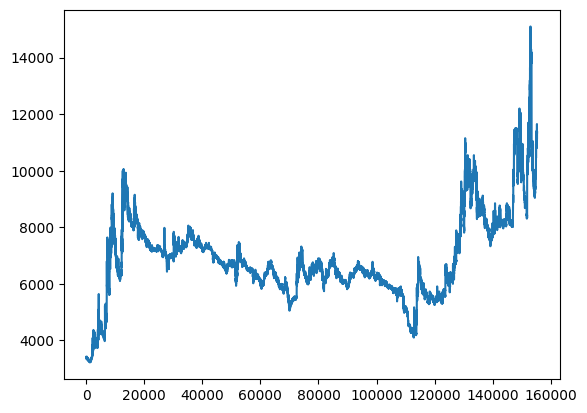

In [8]:
import matplotlib.pyplot as plt

plt.plot(res_df_.close.values)

# plt.plot(res_df_.iloc[:valid_idx[-1]].close)
# plt.plot(res_df_adj_.iloc[:valid_idx[-1]].close)

# plt.plot(res_df_adj_.close)

# legacy

# olds

In [ ]:
# ------ load ftr list ------ #
ticker = 'A005930' # ETH RUNE FTM
data_list = [s for s in os.listdir(data_path) if "parquet" in s if date in s if ticker in s if '_1.' in s]
print(data_list)

start_0 = time.time()
key = data_list[0]  # tempoaray use single key
# res_df_ = pd.read_csv(os.path.join(data_path, key), index_col=0) # .set_index("index")
res_df_adj_ = pd.read_parquet(os.path.join(data_path, key)) #.set_index("date")
# print(res_df_.head())
print(key, "loaded !")
print("load res_df_ elapsed time :", time.time() - start_0)

['20221218 A005930_15_1.parquet']
20221218 A005930_15_1.parquet loaded !
load res_df_ elapsed time : 0.003991842269897461


In [4]:
account_num = kiwoom.GetLoginInfo("ACCOUNT_CNT")        # 전체 계좌수
accounts = kiwoom.GetLoginInfo("ACCNO")                 # 전체 계좌 리스트
user_id = kiwoom.GetLoginInfo("USER_ID")                # 사용자 ID
user_name = kiwoom.GetLoginInfo("USER_NAME")            # 사용자명
keyboard = kiwoom.GetLoginInfo("KEY_BSECGB")            # 키보드보안 해지여부
firewall = kiwoom.GetLoginInfo("FIREW_SECGB")           # 방화벽 설정 여부

print(account_num)
print(accounts)
print(user_id)
print(user_name)
print(keyboard)
print(firewall)

1
['8037568711']
nave94
장재원
0
0


In [83]:
kospi = kiwoom.GetCodeListByMarket('0')
kosdaq = kiwoom.GetCodeListByMarket('10')
etf = kiwoom.GetCodeListByMarket('8')

print(len(kospi))# , kospi)
print(len(kosdaq))# , kosdaq)
print(len(etf))# , etf)

1962
1616
663


In [84]:
name = kiwoom.GetMasterCodeName(code_str)
stock_cnt = kiwoom.GetMasterListedStockCnt(code_str)
stock_const = kiwoom.GetMasterConstruction(code_str)

print(name)
print(stock_cnt)
print(stock_const)

삼성전자
2147483647
정상


In [ ]:
trcode = "opt10019" # opt10001"

df = kiwoom.block_request(trcode,
                          종목코드="005930",
                          output="주식기본정보",
                          next=0)

In [32]:
df.columns

Index(['종목코드', '종목명', '결산월', '액면가', '자본금', '상장주식', '신용비율', '연중최고', '연중최저',
       '시가총액', '시가총액비중', '외인소진률', '대용가', 'PER', 'EPS', 'ROE', 'PBR', 'EV',
       'BPS', '매출액', '영업이익', '당기순이익', '250최고', '250최저', '시가', '고가', '저가',
       '상한가', '하한가', '기준가', '예상체결가', '예상체결수량', '250최고가일', '250최고가대비율',
       '250최저가일', '250최저가대비율', '현재가', '대비기호', '전일대비', '등락율', '거래량', '거래대비',
       '액면가단위', '유통주식', '유통비율'],
      dtype='object')

In [ ]:
import numpy as np
import time

kospi_data = []
kosdag_data = []
etf_data = []

# df.values
for code_str_ in (kospi):
    print(code_str_)
    kospi_data.append(kiwoom.block_request("opt10001",
                          종목코드=code_str_,
                          output="주식기본정보",
                          next=0).values)
    time.sleep(0.5)

In [ ]:
np.array(kospi_data).shape
kospi_data